# Capsule Networks (CapsNets)

# Imports

In [1]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Reproducibility

In [2]:
tf.reset_default_graph()
np.random.seed(42)
tf.set_random_seed(42)

# Load MNIST

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


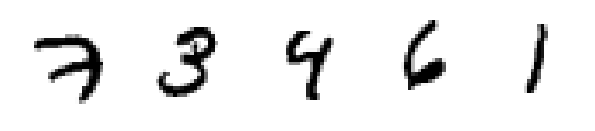

In [4]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

And these are the corresponding labels:

In [5]:
mnist.train.labels[:n_samples]

array([7, 3, 4, 6, 1], dtype=uint8)

# Input Images

In [6]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")

# Primary Capsules

In [7]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8

In [8]:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

In [9]:
conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)

In [10]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],name="caps1_raw")

In [11]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

In [12]:
caps1_output = squash(caps1_raw, name="caps1_output")

# Digit Capsules

## Compute the Predicted Output Vectors

In [13]:
caps2_n_caps = 10
caps2_n_dims = 16

In [14]:
init_sigma = 0.01

W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

In [15]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

In [16]:
batch_size

<tf.Tensor 'strided_slice:0' shape=() dtype=int32>

In [21]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

In [24]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

## Routing by agreement

In [26]:
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")

### Round 1

In [28]:
routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")


In [30]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                             name="weighted_sum")

In [33]:
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

### Round 2

In [37]:
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

In [39]:
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")

In [41]:
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")

The rest of round 2 is the same as in round 1:

In [43]:
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        dim=2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")

In [48]:
caps2_output = caps2_output_round_2

# Estimated Class Probabilities (Length)

In [52]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [53]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

In [55]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

In [57]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

# Labels

In [59]:
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

# Margin loss

In [61]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

In [62]:
T = tf.one_hot(y, depth=caps2_n_caps, name="T")

In [66]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

In [68]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                           name="present_error")

In [71]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                          name="absent_error")

We are ready to compute the loss for each instance and each digit:

In [74]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

In [76]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

# Reconstruction

## Mask

We need a placeholder to tell TensorFlow whether we want to mask the output vectors based on the labels (`True`) or on the predictions (`False`, the default):

In [78]:
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

In [79]:
mask_with_labels

<tf.Tensor 'mask_with_labels:0' shape=() dtype=bool>

Now let's use `tf.cond()` to define the reconstruction targets as the labels `y` if `mask_with_labels` is `True`, or `y_pred` otherwise.

In [80]:
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

In [81]:
reconstruction_targets

<tf.Tensor 'reconstruction_targets/Merge:0' shape=(?,) dtype=int64>

Note that the `tf.cond()` function expects the if-True and if-False tensors to be passed _via_ functions: these functions will be called just once during the graph construction phase (not during the execution phase), similar to `tf.while_loop()`. This allows TensorFlow to add the necessary operations to handle the conditional evaluation of the if-True or if-False tensors. However, in our case, the tensors `y` and `y_pred` are already created by the time we call `tf.cond()`, so unfortunately TensorFlow will consider both `y` and `y_pred` to be dependencies of the `reconstruction_targets` tensor. The `reconstruction_targets` tensor will end up with the correct value, but:
1. whenever we evaluate a tensor that depends on `reconstruction_targets`, the `y_pred` tensor will be evaluated (even if `mask_with_layers` is `True`). This is not a big deal because computing `y_pred` adds no computing overhead during training, since we need it anyway to compute the margin loss. And during testing, if we are doing classification, we won't need reconstructions, so `reconstruction_targets` won't be evaluated at all.
2. we will always need to feed a value for the `y` placeholder (even if `mask_with_layers` is `False`). This is a bit annoying, but we can pass an empty array, because TensorFlow won't use it anyway (it just does not know it yet when it checks for dependencies).

Now that we have the reconstruction targets, let's create the reconstruction mask. It should be equal to 1.0 for the target class, and 0.0 for the other classes, for each instance. For this we can just use the `tf.one_hot()` function:

In [82]:
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")

Let's check the shape of `reconstruction_mask`:

In [83]:
reconstruction_mask

<tf.Tensor 'reconstruction_mask:0' shape=(?, 10) dtype=float32>

Let's compare this to the shape of `caps2_output`:

In [84]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

Mmh, its shape is (_batch size_, 1, 10, 16, 1). We want to multiply it by the `reconstruction_mask`, but the shape of the `reconstruction_mask` is (_batch size_, 10). We must reshape it to (_batch size_, 1, 10, 1, 1) to make multiplication possible:

In [85]:
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")

In [86]:
reconstruction_mask_reshaped

<tf.Tensor 'reconstruction_mask_reshaped:0' shape=(?, 1, 10, 1, 1) dtype=float32>

At last! We can apply the mask:

In [87]:
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

In [88]:
caps2_output_masked

<tf.Tensor 'caps2_output_masked:0' shape=(?, 1, 10, 16, 1) dtype=float32>

One last reshape operation to flatten the decoder's inputs:

This gives us an array of shape (_batch size_, 160):

In [90]:
decoder_input

<tf.Tensor 'decoder_input:0' shape=(?, 160) dtype=float32>

## Decoder

Now let's build the decoder. It's quite simple: two dense (fully connected) ReLU layers followed by a dense output sigmoid layer:

In [91]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

In [92]:
with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")

## Reconstruction Loss

Now let's compute the reconstruction loss. It is just the squared difference between the input image and the reconstructed image:

In [93]:
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_sum(squared_difference,
                                    name="reconstruction_loss")

In [94]:
X_flat

<tf.Tensor 'X_flat:0' shape=(?, 784) dtype=float32>

In [95]:
squared_difference

<tf.Tensor 'squared_difference:0' shape=(?, 784) dtype=float32>

In [96]:
reconstruction_loss

<tf.Tensor 'reconstruction_loss:0' shape=() dtype=float32>

## Final Loss

The final loss is the sum of the margin loss and the reconstruction loss (scaled down by a factor of 0.0005 to ensure the margin loss dominates training):

In [97]:
alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

# Final Touches

## Accuracy

To measure our model's accuracy, we need to count the number of instances that are properly classified. For this, we can simply compare `y` and `y_pred`, convert the boolean value to a float32 (0.0 for False, 1.0 for True), and compute the mean over all the instances:

In [98]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [99]:
correct

<tf.Tensor 'correct:0' shape=(?,) dtype=bool>

In [100]:
accuracy

<tf.Tensor 'accuracy:0' shape=() dtype=float32>

## Training Operations

The paper mentions that the authors used the Adam optimizer with TensorFlow's default parameters:

In [101]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
training_op = optimizer.minimize(loss, name="training_op")

## Init and Saver

And let's add the usual variable initializer, as well as a `Saver`:

In [102]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And... we're done with the construction phase! Please take a moment to celebrate. :)

# Training

Training our capsule network is pretty standard. For simplicity, we won't do any fancy hyperparameter tuning, dropout or anything, we will just run the training operation over and over again, displaying the loss, and at the end of each epoch, measure the accuracy on the validation set, display it, and save the model if the validation loss is the lowest seen found so far (this is a basic way to implement early stopping, without actually stopping). Hopefully the code should be self-explanatory, but here are a few details to note:
* if a checkpoint file exists, it will be restored (this makes it possible to interrupt training, then restart it later from the last checkpoint),
* we must not forget to feed `mask_with_labels=True` during training,
* during testing, we let `mask_with_labels` default to `False` (but we still feed the labels since they are required to compute the accuracy),
* the images loaded _via_ `mnist.train.next_batch()` are represented as `float32` arrays of shape \[784\], but the input placeholder `X` expects a `float32` array of shape \[28, 28, 1\], so we must reshape the images before we feed them to our model,
* we evaluate the model's loss and accuracy on the full validation set (5,000 instances). To view progress and support systems that don't have a lot of RAM, the code evaluates the loss and accuracy on one batch at a time, and computes the mean loss and mean accuracy at the end.

*Warning*: if you don't have a GPU, training will take a very long time (at least a few hours). With a GPU, it should take just a few minutes per epoch (e.g., 6 minutes on an NVidia GeForce GTX 1080Ti).

In [103]:
n_epochs = 2
batch_size = 10
restore_checkpoint = True

n_iterations_per_epoch = mnist.train.num_examples // batch_size
n_iterations_validation = mnist.validation.num_examples // batch_size
best_loss_val = np.infty
checkpoint_path = "./extra_capsnets/my_capsule_network"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Epoch: 1  Val accuracy: 98.1200%  Loss: 0.181039 (improved)
Epoch: 2  Val accuracy: 98.9000%  Loss: 0.133425 (improved)


Training is finished, we reached over 99.3% accuracy on the validation set after just 5 epochs, things are looking good. Now let's evaluate the model on the test set.

# Evaluation

In [104]:
n_iterations_test = mnist.test.num_examples // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./extra_capsnets/my_capsule_network
Final test accuracy: 98.9400%  Loss: 0.134184     


We reach 99.43% accuracy on the test set. Pretty nice. :)

# Predictions

Now let's make some predictions! We first fix a few images from the test set, then we start a session, restore the trained model, evaluate `caps2_output` to get the capsule network's output vectors, `decoder_output` to get the reconstructions, and `y_pred` to get the class predictions:

In [105]:
n_samples = 5

sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

INFO:tensorflow:Restoring parameters from ./extra_capsnets/my_capsule_network


Note: we feed `y` with an empty array, but TensorFlow will not use it, as explained earlier.

And now let's plot the images and their labels, followed by the corresponding reconstructions and predictions:

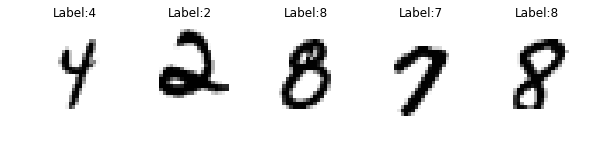

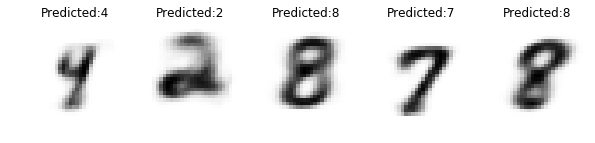

In [106]:
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(mnist.test.labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()


The predictions are all correct, and the reconstructions look great. Hurray!

# Interpreting the Output Vectors

Let's tweak the output vectors to see what their pose parameters represent.

First, let's check the shape of the `cap2_output_value` NumPy array:

In [107]:
caps2_output_value.shape

(5, 1, 10, 16, 1)

Let's create a function that will tweak each of the 16 pose parameters (dimensions) in all output vectors. Each tweaked output vector will be identical to the original output vector, except that one of its pose parameters will be incremented by a value varying from -0.5 to 0.5. By default there will be 11 steps (-0.5, -0.4, ..., +0.4, +0.5). This function will return an array of shape (_tweaked pose parameters_=16, _steps_=11, _batch size_=5, 1, 10, 16, 1):

In [108]:
def tweak_pose_parameters(output_vectors, min=-0.5, max=0.5, n_steps=11):
    steps = np.linspace(min, max, n_steps) # -0.25, -0.15, ..., +0.25
    pose_parameters = np.arange(caps2_n_dims) # 0, 1, ..., 15
    tweaks = np.zeros([caps2_n_dims, n_steps, 1, 1, 1, caps2_n_dims, 1])
    tweaks[pose_parameters, :, 0, 0, 0, pose_parameters, 0] = steps
    output_vectors_expanded = output_vectors[np.newaxis, np.newaxis]
    return tweaks + output_vectors_expanded

Let's compute all the tweaked output vectors and reshape the result to (_parameters_×_steps_×_instances_, 1, 10, 16, 1) so we can feed the array to the decoder:

In [109]:
n_steps = 11

tweaked_vectors = tweak_pose_parameters(caps2_output_value, n_steps=n_steps)
tweaked_vectors_reshaped = tweaked_vectors.reshape(
    [-1, 1, caps2_n_caps, caps2_n_dims, 1])

Now let's feed these tweaked output vectors to the decoder and get the reconstructions it produces:

In [110]:
tweak_labels = np.tile(mnist.test.labels[:n_samples], caps2_n_dims * n_steps)

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    decoder_output_value = sess.run(
            decoder_output,
            feed_dict={caps2_output: tweaked_vectors_reshaped,
                       mask_with_labels: True,
                       y: tweak_labels})

INFO:tensorflow:Restoring parameters from ./extra_capsnets/my_capsule_network


Let's reshape the decoder's output so we can easily iterate on the output dimension, the tweak steps, and the instances:

In [111]:
tweak_reconstructions = decoder_output_value.reshape(
        [caps2_n_dims, n_steps, n_samples, 28, 28])

Lastly, let's plot all the reconstructions, for the first 3 output dimensions, for each tweaking step (column) and each digit (row):

Tweaking output dimension #0


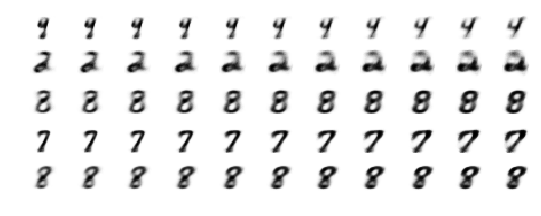

Tweaking output dimension #1


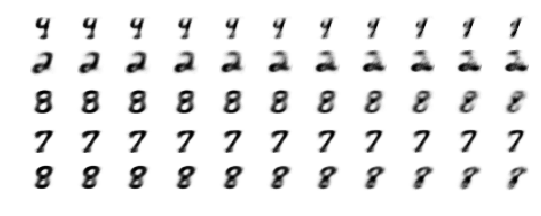

Tweaking output dimension #2


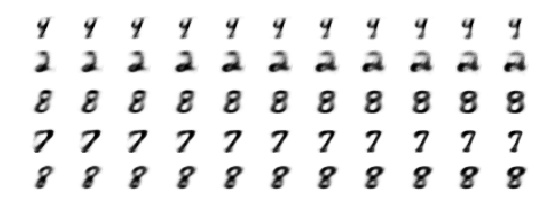

In [112]:
for dim in range(3):
    print("Tweaking output dimension #{}".format(dim))
    plt.figure(figsize=(n_steps / 1.2, n_samples / 1.5))
    for row in range(n_samples):
        for col in range(n_steps):
            plt.subplot(n_samples, n_steps, row * n_steps + col + 1)
            plt.imshow(tweak_reconstructions[dim, col, row], cmap="binary")
            plt.axis("off")
    plt.show()

# Conclusion

I tried to make the code in this notebook as flat and linear as possible, to make it easier to follow, but of course in practice you would want to wrap the code in nice reusable functions and classes. For example, you could try implementing your own `PrimaryCapsuleLayer`, and `DenseRoutingCapsuleLayer` classes, with parameters for the number of capsules, the number of routing iterations, whether to use a dynamic loop or a static loop, and so on. For an example a modular implementation of Capsule Networks based on TensorFlow, take a look at the [CapsNet-TensorFlow](https://github.com/naturomics/CapsNet-Tensorflow) project.

That's all for today, I hope you enjoyed this notebook!